In [ ]:
%load_ext autoreload
%autoreload 2

In [7]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
BRISC = importr('BRISC')
def BRISC_estimation(residual, X, coord):
    residual_r = robjects.FloatVector(residual)
    coord_r = robjects.FloatVector(coord.transpose().reshape(-1))
    coord_r = robjects.r['matrix'](coord_r, ncol=2)

    if X is None:
        res = BRISC.BRISC_estimation(coord_r, residual_r)
    else:
        Xr = robjects.FloatVector(X.transpose().reshape(-1))
        Xr = robjects.r['matrix'](Xr, ncol=X.shape[1])
        res = BRISC.BRISC_estimation(coord_r, residual_r, Xr)

    theta_hat = res[9]
    beta = res[8]
    beta = np.array(beta)
    theta_hat = np.array(theta_hat)
    phi = theta_hat[2]
    tau_sq = theta_hat[1]
    sigma_sq = theta_hat[0]
    theta_hat[1] = phi
    theta_hat[2] = tau_sq / sigma_sq

    return beta, theta_hat

In [2]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
def f5(X): return (10*np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2]-0.5)**2 + 10*X[:,3] +5*X[:,4])/6
def f1(X): return 5*X + 2

sigma = 1
phi = 3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 1; funXY = f1

n = 1000
nn = 20
batch_size = 50

torch.manual_seed(2024)
X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, 10])

data = geospaNN.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size = nn, 
                                                   test_proportion = 0.2)

In [31]:
torch.manual_seed(2024)
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
nn_model = geospaNN.nn_train(mlp_nn, lr =  0.01, min_delta = 0.001)
training_log = nn_model.train(data_train, data_val, data_test)
theta0 = geospaNN.theta_update(torch.tensor([1, 1.5, 0.01]), mlp_nn(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size = 20)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
nngls_model = geospaNN.nngls_train(model, lr =  0.01, min_delta = 0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init = 10, Update_step = 5)

Epoch 00021: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping
End at epoch23
Theta updated from
[1.   1.5  0.01]
Theta updated from
[1.20244225 1.95949652 0.        ]
to
[1.21454359 1.89104703 0.00546051]
Theta updated from
[1.21454359 1.89104703 0.00546051]
to
[1.19323792 1.92449587 0.00663631]
Theta updated from
[1.19323792 1.92449587 0.00663631]
to
[1.19367785 1.92453759 0.00648761]
Epoch 00021: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping
End at epoch24


In [35]:
X_np = np.concatenate([data_train.x.detach().numpy(), data_val.x.detach().numpy()], axis = 0)
n_train = X_np.shape[0]
X_np_int = np.concatenate((X_np, np.repeat(1, n_train).reshape(n_train, 1)), axis=1)
n_test = data_test.x.shape[0]
X_test_int = torch.concatenate((data_test.x, torch.from_numpy(np.repeat(1, n_test).reshape(n_test, 1))), axis=1)
Y_np = np.concatenate([data_train.y.detach().numpy(), data_val.y.detach().numpy()], axis = 0)
coord_np = np.concatenate([data_train.pos.detach().numpy(), data_val.pos.detach().numpy()], axis = 0)

In [36]:
X_np.shape

(800, 1)

In [39]:
torch.manual_seed(2024)
np.random.seed(2024)
beta, theta_hat_linear = BRISC_estimation(Y_np, X_np_int, coord_np)
def model_BRISC(X, edge_index = 0):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X).float()
    return(torch.matmul(X, torch.from_numpy(beta).float()))
theta_hat_linear

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 800 observations.

Number of covariates 2 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------


array([1.16544065, 1.85772445, 0.01273631])

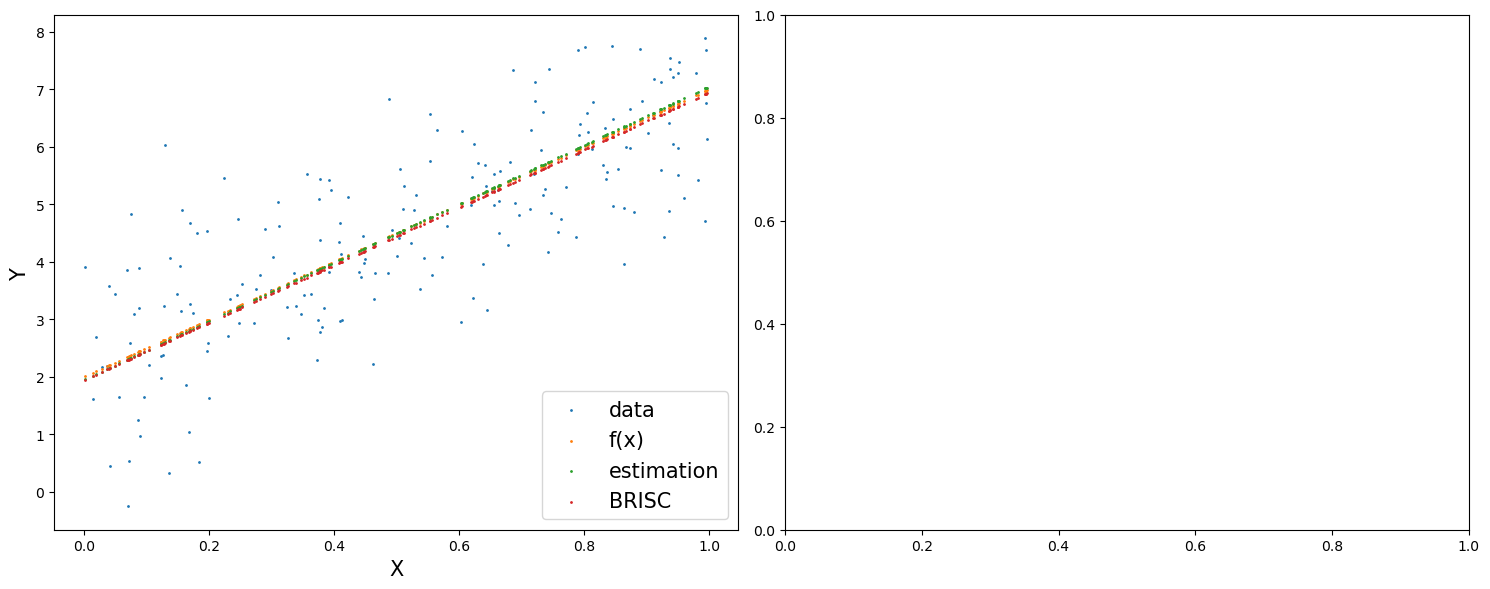

In [50]:
#test_predict = model.predict(data_train, data_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(data_test.x.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'data')
axes[0].scatter(data_test.x.detach().numpy(), funXY(data_test.x.detach().numpy()), s = 1, label = 'f(x)')
axes[0].scatter(data_test.x.detach().numpy(), mlp_nngls(data_test.x).detach().numpy(), s = 1, label = 'estimation')
axes[0].scatter(data_test.x.detach().numpy(), model_BRISC(X_test_int).detach().numpy(), s = 1, label = 'BRISC')
#axes[0].scatter(data_test.x.detach().numpy(), test_predict.detach().numpy(), s = 1, label = 'prediction')
axes[0].set_xlabel('X', fontsize=15)
axes[0].set_ylabel('Y', fontsize=15)
axes[0].legend(prop={'size': 15})
plt.tight_layout()

In [45]:
data.x.shape

torch.Size([1000, 1])

In [ ]:
axes[1].scatter(test_predict.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'Truth vs prediction')
axes[1].scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'reference')
axes[1].set_xlabel("Prediction", fontsize=15)
axes[1].set_ylabel("Truth", fontsize=15)
axes[1].legend(prop={'size': 15})
plt.tight_layout()